Stochastic differential equations:
$$ dx = \mu_x(-k_x x[t] + k_{int} y[t])dt + \sqrt{2\mu_x D_x dt} \delta_x[t] $$
$$ dy = \mu_y(-k_y y[t] + k_{int} x[t] + f[t])dt + \sqrt{2\mu_y D_y dt} \delta_y[t] $$
$$ df = -\frac{f[t]}{\tau} dt + \sqrt{\frac{2\epsilon^2 dt}{\tau}} \delta_f[t] $$

Theoretical things:
- OT stretching, OT sensing, and OM refer to different techniques used to measure the mechanical properties of red blood cells (RBCs). OT stretching involves mechanically stretching RBCs using beads nonspecifically attached to the membrane with different optical trap stiffness. OT sensing, on the other hand, measures cell contour fluctuations by membrane flickering segmentation tracking of free-standing RBCs using ultrafast optical microscopy (OM). These techniques are used to study the deformability and mechanical properties of RBCs

Parameters, prior:
- Sampling rates = 40 kHz for OT stretching, 25 kHz for OT sensing, 2 kHz for OM
Considering 40 kHz as sampling rate, and 30 s the duration of the experiment. We need to sample 1.2e6 points.
So if the frequency is 40 kHz, in our simulation we need to have this relation:
$$\text{{Total simulation time}} = dt \times \text{{Number of steps}}$$ 
$$30 \, \text{{s}} = dt \times \text{{Number of steps}}$$
- Parameters 

| RBC | $k_x$ [10^-3 pN/nm] | $\mu_x$ [10^4 nm/(pN s)] | $k_y$ [10^-2 pN/nm] | $\mu_y$ [10^4 nm/(pN s)] | $k_{int}$ [10^-3 pN/nm] | $\varepsilon$ [pN] | $\tau$ [10^-2 s] | $\Theta$ [10^2 kB T/s] |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| P1 | 6.0±0.7 | 2.6±0.3 | 1.7±0.5 | 140±10 | 1.8±0.6 | 0.7±0.1 | (2±1)·10^2 | 1.3±0.2 |
| P2 | 8.1±0.5 | 2.1±0.4 | 29±8 | 31±8 | 6±2 | 2.1±0.5 | (4±1)·10^2 | 0.8±0.1 |
| H1 | 6.5±0.6 | 2.8±0.5 | 1.6±0.2 | 2.9±0.4 | 4.5±0.5 | 2.6±0.1 | 8±1 | 16±2 |
| H2 | 15.1±0.2 | 3.6±0.4 | 1.6±0.1 | 2.3±0.3 | 4.2±0.2 | 2.4±0.1 | 1.1±0.1 | 64±3 |
| H3 | 3.7±0.6 | 2.6±0.2 | 2.9±0.5 | 0.57±0.08 | 2.3±0.4 | 4.7±0.3 | 2.5±0.3 | 10±2 |
| H4 | 7.17±0.03 | 1.6±0.1 | 1.30±0.05 | 1.96±0.02 | 2.88±0.05 | 3.86±0.02 | 17±3 | 22±4 |
| H5 | 9.5±0.4 | 1.7±0.2 | 1.78±0.06 | 1.94±0.02 | 2.84±0.06 | 4.41±0.03 | 7.7±0.1 | 39±5 |

- Prior distributions,, we can just take the uniform distribution in those ranges without rescaling or anything, since the units of measurement are alsways in nm, pN and s.

| Parameter      | Prior Distribution (Range) |
| ----------- | ----------- |
| $k_{x}$     | $\mathcal{U}(3, 16)$ pN/nm   $10^-3$    | 
| $k_{y}$  | $\mathcal{U}(1.5, 30)$ pN/nm  $10^-2$        |
| $k_{int}$ | $\mathcal{U}(1, 6)$ pN/nm  $10^-3$ |
| $u_{x}$ | $\mathcal{U}(1.5, 4)$ nm/ (pN s) $10^4$ |
| $u_{y}$ | $\mathcal{U}(1, 140)$ nm/ (pN s) $10^4$ |
| $\varepsilon$ | $\mathcal{U}(0.5, 6)$ pN |
| $\tau$ | $\mathcal{U}(2, 20)$ s $10^-2$ |
| $\sigma$ | $\mathcal{U}(4, 260)$ (pN nm)/ s |
| $D_{x}$ | $\mathcal{U}(5.5, 15.5)$ nm ^2 / s |
| $D_{y}$ | $\mathcal{U}(1, 530)$ nm ^2 / s|


| Parameter      | Prior Distribution (Range) |
| ----------- | ----------- |
| $k_{x}$     | $\mathcal{U}(3 \times 10^{-3}, 16 \times 10^{-3})$ pN/nm       |
| $k_{y}$  | $\mathcal{U}(1.5 \times 10^{-2}, 30 \times 10^{-2})$ pN/nm        |
| $k_{int}$ | $\mathcal{U}(1 \times 10^{-3}, 6 \times 10^{-3})$ pN/nm |
| $u_{x}$ | $\mathcal{U}(1.5 \times 10^{4}, 4 \times 10^{4})$ nm/(pN s) |
| $u_{y}$ | $\mathcal{U}(1 \times 10^{4}, 140 \times 10^{4})$ nm/(pN s) |
| $\varepsilon$ | $\mathcal{U}(0.5, 6)$ pN |
| $\tau$ | $\mathcal{U}(2 \times 10^{-2}, 20 \times 10^{-2})$ s |
| $\sigma$ | $\mathcal{U}(4, 260)$ (pN nm)/s |
| $D_{x}$ | $\mathcal{U}(5.5, 15.5)$ nm²/s |
| $D_{y}$ | $\mathcal{U}(1, 530)$ nm²/s |

In [1]:
from numba import jit
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# First simulator (not updated)

TO DO
- Fix the time steps (the relation between dt and simul time)
- Implement sampling time != dt
- The process is Markovin: we can extend the dynamics starting from the end of a simulation (less memory intensive if we use a sampling time different from the integration time)

### CPU 

In [5]:
def corr(x,y,nmax,dt=False):
    '''fft, pad 0s, non partial'''

    assert len(x)==len(y)

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    yp=y-np.mean(y)

    # do fft and ifft
    cfx=np.fft.fft(xp,fsize)
    cfy=np.fft.fft(yp,fsize)
    if dt != False:
        freq = np.fft.fftfreq(n, d=dt)
        idx = np.where((freq<-1/(2*dt))+(freq>1/(2*dt)))[0]
        
        cfx[idx]=0
        cfy[idx]=0
        
    sf=cfx.conjugate()*cfy
    corr=np.fft.ifft(sf).real
    corr=corr/n

    return corr[:nmax]

In [6]:
@jit
def simul(N, simul_time, dt, params, random_numbers, init_state=None):
    """
    - simul_time: number of integration time steps
    """
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps = params
    
    # Unpack stochastic variables (needed for numba)
    delta_x = random_numbers[0]
    delta_y = random_numbers[1]
    delta_f = random_numbers[2]

    # Initialize state variables
    x = np.zeros((N, simul_time))
    y = np.zeros((N, simul_time))
    f = np.zeros((N, simul_time))

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0]
        y[:, 0] = init_state[1]
        f[:, 0] = init_state[2]

    # Time evolution (Langvine dynamics)
    for t in range(simul_time-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + np.sqrt(2*mu_x*D_x*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + np.sqrt(2*mu_y*D_y*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + np.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
         
    return x, y, f

In [7]:
def run_simul(N, simul_time, dt):
    
    N, simul_time = int(N), int(simul_time)

    #Define the parameters (drawn from the uniform prior)
    # mu_x = np.random.uniform(0.1, 0.5, size=N)
    # mu_y = np.random.uniform(0.1, 0.5, size=N)
    # k_x = np.random.uniform(0.1, 0.5, size=N)
    # k_y = np.random.uniform(0.1, 0.5, size=N)
    # k_int = np.random.uniform(0.1, 0.5, size=N)
    # D_x = np.random.uniform(0.1, 0.5, size=N)
    # D_y = np.random.uniform(0.1, 0.5, size=N)
    # tau = np.random.uniform(0.1, 0.5, size=N)
    # eps = np.random.uniform(0.1, 0.5, size=N)


    k_x = np.random.uniform(3e-3, 16e-3, size=N)
    k_y = np.random.uniform(1.5e-2, 30e-2, size=N)
    k_int = np.random.uniform(1e-3, 6e-3, size=N)
    mu_x = np.random.uniform(1.5e4, 4e4, size=N)
    mu_y = np.random.uniform(1e4, 140e4, size=N)
    eps = np.random.uniform(0.5, 6, size=N)
    tau = np.random.uniform(2e-2, 20e-2, size=N)
    sigma = np.random.uniform(4, 260, size=N)
    D_x = np.random.uniform(5.5, 15.5, size=N)
    D_y = np.random.uniform(1, 530, size=N)


    # Initial state
    init_state = [np.random.normal(0, 1, size=N), 
                  np.random.normal(0, 1, size=N), 
                  np.random.normal(0, 1, size=N)]

    # Generate random numbers for the stochastic variables
    delta_x = np.random.normal(0, 1, size=(N, simul_time))
    delta_y = np.random.normal(0, 1, size=(N, simul_time))
    delta_f = np.random.normal(0, 1, size=(N, simul_time))
    random_numbers = [delta_x, delta_y, delta_f]

    # Run the N simulations in parallel
    x, y, f = simul(N, simul_time=simul_time, dt=dt, 
                    params=[mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps], 
                    random_numbers=random_numbers, init_state=init_state)
    
    del mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps
    del delta_x, delta_y, delta_f, random_numbers

    return x, y, f

In [8]:
# Easy call to the simulation to compile simul()
# remember that N * dt should be more or less between 10 and 30
x, y, f = run_simul(N=2, simul_time=1000, dt=0.01)

In [18]:
%%time
x, y, f = run_simul(N=1e1, simul_time=3e5, dt=1e-6)

CPU times: user 324 ms, sys: 36.3 ms, total: 361 ms
Wall time: 360 ms


In [10]:
# normalize x
def normalize_numpy(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

x_normalized = normalize_numpy(x[0])

In [11]:
print(corr(x_normalized, x_normalized, 1000, dt=1e-6))

[0.01822025 0.01821514 0.01821001 0.01820487 0.01819972 0.0181946
 0.01818949 0.01818436 0.01817925 0.01817417 0.01816908 0.01816399
 0.0181589  0.01815382 0.01814875 0.01814368 0.01813861 0.01813357
 0.01812856 0.01812359 0.01811864 0.01811368 0.01810873 0.01810378
 0.01809885 0.01809394 0.01808904 0.01808416 0.0180793  0.01807445
 0.01806964 0.01806485 0.01806009 0.01805534 0.0180506  0.01804583
 0.01804106 0.01803629 0.01803155 0.01802678 0.01802201 0.01801722
 0.01801243 0.01800762 0.01800281 0.01799799 0.01799317 0.01798835
 0.01798354 0.01797873 0.01797394 0.01796913 0.01796434 0.01795958
 0.01795481 0.01795005 0.0179453  0.01794053 0.01793578 0.01793103
 0.01792628 0.01792149 0.0179167  0.01791191 0.01790709 0.0179023
 0.01789756 0.01789278 0.01788804 0.01788327 0.0178785  0.01787374
 0.01786898 0.0178642  0.01785941 0.01785462 0.01784982 0.01784501
 0.0178402  0.01783536 0.01783051 0.01782566 0.01782081 0.01781598
 0.01781113 0.01780626 0.01780139 0.01779654 0.01779169 0.017786

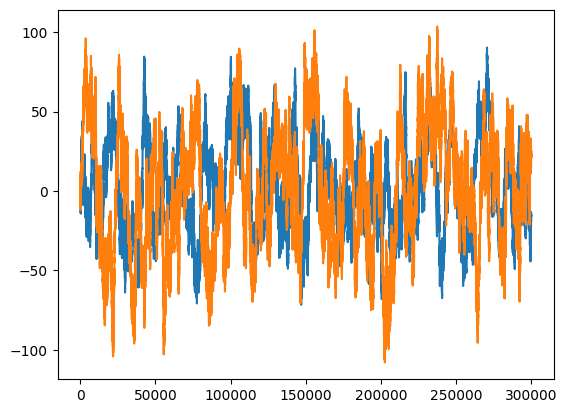

In [19]:
for n in range(2):
    plt.plot(x[n,:], label=f"Trajectory {n}")

In [ ]:
%%time
N, times = int(1e4), 10
T = int(1e3)

x = np.zeros((N*times, T))
y = np.zeros((N*times, T))
f = np.zeros((N*times, T))

for t in tqdm(range(times)):
    x_t, y_t, f_t = run_simul(N, T)

    x[N*t:N*(t+1), :] = x_t
    x[N*t:N*(t+1), :] = y_t
    x[N*t:N*(t+1), :] = f_t

    #time.sleep(1)

### GPU with torch

NOT UPDATED!!!

In [ ]:
def simul_torch(N, T, dt, params, random_numbers, init_state=None, device='cpu'):
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps = params
    
    # Unpack stochastic variables
    delta_x, delta_y, delta_f = random_numbers

    # Initialize state variables as PyTorch tensors
    x = torch.zeros((N, T), dtype=torch.float64, device=device)
    y = torch.zeros((N, T), dtype=torch.float64, device=device)
    f = torch.zeros((N, T), dtype=torch.float64, device=device)

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0].clone().detach().to(torch.float64)
        y[:, 0] = init_state[1].clone().detach().to(torch.float64)
        f[:, 0] = init_state[2].clone().detach().to(torch.float64)

    # Time evolution (Langvine dynamics)
    for t in range(T-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + torch.sqrt(2*mu_x*D_x*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + torch.sqrt(2*mu_y*D_y*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + torch.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
        
    return x, y, f


In [ ]:
def run_simul_torch(N, T):
    N, T = int(N), int(T)

    # Define the parameters (drawn from the uniform prior)
    mu_x = torch.rand(N) * 0.4 + 0.1
    mu_y = torch.rand(N) * 0.4 + 0.1
    k_x = torch.rand(N) * 0.4 + 0.1
    k_y = torch.rand(N) * 0.4 + 0.1
    k_int = torch.rand(N) * 0.4 + 0.1
    D_x = torch.rand(N) * 0.4 + 0.1
    D_y = torch.rand(N) * 0.4 + 0.1
    tau = torch.rand(N) * 0.4 + 0.1
    eps = torch.rand(N) * 0.4 + 0.1

    # Initial state
    init_state = [
        torch.normal(-20, 20, size=(N,)).clone().detach(),
        torch.normal(-20, 20, size=(N,)).clone().detach(),
        torch.normal(-0.5, 0.5, size=(N,)).clone().detach()
    ]

    # Generate random numbers for the stochastic variables
    delta_x = torch.normal(0, 1, size=(N, T))
    delta_y = torch.normal(0, 1, size=(N, T))
    delta_f = torch.normal(0, 1, size=(N, T))
    random_numbers = [delta_x, delta_y, delta_f]

    # Run the N simulations in parallel
    x, y, f = simul_torch(N, T, 0.01, [mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps], 
                          random_numbers, init_state, device='cpu')

    return x, y, f


In [ ]:
# Trying the same with torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using '" + str('cuda' if torch.cuda.is_available() else 'cpu') + "' as device")
x, y, f = run_simul_torch(N=2, T=100)

# Complexity analysis

In [25]:
from SuperSonic import Simulator_noGPU

dt = 0.1
DeltaT = 1
TotalT = 100
n_sim = 100
theta = [np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)),np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1))]

In [26]:
%%time
x_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11.4 ms


### Single run complexity

In [27]:
n = np.logspace(2, 8, num=5, base=10, dtype=int)
times_n_sim = []
times_totalT = []

In [28]:
# Complexity on n_simul
for i in n:
    n_sim = i
    theta = [np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)),np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1))]

    start = time.time()
    x_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)
    stop = time.time()

    print(i, stop - start)
    times_n_sim.append(stop - start)

100 0.013124942779541016
3162 0.31635236740112305


SystemError: CPUDispatcher(<function Simulator_noGPU at 0x79a0bf672950>) returned a result with an exception set

In [ ]:
# Complexity on totalT
n_sim = 100
theta = [np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)),np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1)), np.ones((n_sim,1))]

for i in n:
    totalT = i
    
    start = time.time()
    x_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta)
    stop = time.time()

    print(i, stop - start)
    times_n_sim.append(stop - start)

### Multiple run complexity

In [10]:
t_range = [100, 1000, 10000, 100000, 1000000]
rep = 5
times_dir = []
times_markov = []

for t in range(len(t_range)):
    TotalT = t_range[t]
    x_trace_total = np.zeros((n_sim, TotalT*rep))

    start = time.time()
    for c in range(rep):
      x_trace, state = Simulator_noGPU(dt, DeltaT, TotalT, n_sim, theta, i_state=state)
      x_trace_total[:, c*TotalT:(c+1)*TotalT] = x_trace
    stop = time.time()
    times_markov.append(stop - start)

    start = time.time()
    x_trace, state = Simulator_noGPU(dt, DeltaT, TotalT*rep, n_sim, theta, i_state=state)
    stop = time.time()
    times_dir.append(stop - start)

    print(t, times_dir[t], times_markov[t])

0 0.06430721282958984 0.07457470893859863
1 0.6431775093078613 0.7565479278564453
2 6.325743198394775 6.1464457511901855
3 66.20423531532288 65.68721103668213


NameError: name 't_range' is not defined

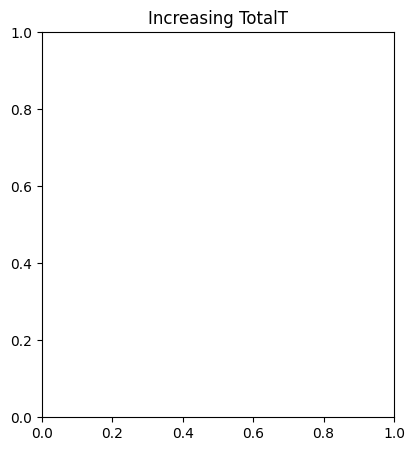

In [29]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title("Increasing TotalT")
plt.scatter(t_range, times_dir, label='Direct')
plt.scatter(t_range, times_markov, label='Markov')
plt.xlabel('TotalT')
plt.ylabel('Time (s)')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.title("Increasing complexity)")
plt.scatter(n, times_n_sim, label="n_sim")
plt.scatter(n, times_totalT, label="TotalT")
plt.xlabel('complexity')
plt.ylabel('Time (s)')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.show();